In [ ]:
import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv3D, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.applications import DenseNet121, densenet
from tensorflow.keras import Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
imdir = '/content/gdrive/MyDrive/MMAI 894 Team Project/data_final/'
df_list = []
img_size = (224, 224)

total_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imdir,
    #label_mode="categorical",
    label_mode="int",
    #validation_split=0.2,
    subset=None,
    seed=1337,
    image_size=img_size,
    #batch_size=batch_size,
    batch_size=None,
    shuffle=False
)

Found 10157 files belonging to 5 classes.


In [ ]:
# Function to create a train, val, test split from a data set object
def get_dataset_partitions_tf(ds, ds_size, train_split=0.5, val_split=0.3, test_split=0.2, shuffle=True, shuffle_size=10000, batch_size=32):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        # Note must set reshuffle_each_iteration to False to avoid data leakage
        ds = ds.shuffle(shuffle_size, seed=12, reshuffle_each_iteration = False)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).batch(batch_size)
    test_ds = ds.skip(train_size).skip(val_size).batch(batch_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
batch_size = 32

# Get the data set size to calculate the right split
# When batched this is the number of batches not item count
batch_count = total_ds.cardinality().numpy()
print(batch_count)

# Split the data into three parts
train_ds, val_ds, test_ds = get_dataset_partitions_tf(total_ds, batch_count, train_split=0.5, 
                                                      val_split=0.3, test_split=0.2, shuffle=True, shuffle_size=10000, batch_size=batch_size)

# Check that the split worked
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())

10157
159
96
64


In [ ]:
def build_model():

    #DenseNet121 model pre-trained on ImageNet, using MAX pooling at output, freeze training on all layers
    base_model = DenseNet121(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))
    for layer in base_model.layers[:149]:
      layer.trainable = False
    for layer in base_model.layers[149:]:
      layer.trainable = True
    
    input_layer = keras.layers.Input([224,224,3])
    pre_process = keras.applications.densenet.preprocess_input(input_layer)

    x = base_model(pre_process)
    dense1 = Dense(1024, activation='relu')(x)
    do1 = Dropout(0.25, seed=42)(dense1)

    dense2 = Dense(1024, activation='relu')(do1)
    do2 = Dropout(0.25, seed=42)(dense2)
    
    output_layer = Dense(5, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))(do2)

    model = Model(input_layer, output_layer)
    model.summary()

    return model

def compile_model(model):

    model.compile(
       #use catgorical crossentropy loss
       loss=keras.losses.sparse_categorical_crossentropy,

       #use Adam gradient descent optimizer
       optimizer=keras.optimizers.Adam(learning_rate=5e-5),
       
       #use accuracy as a metric
       metrics=['accuracy']
    )

    return model

def train_model(model, train, val, epochs = 20):

    #fit model with train data
    history = model.fit(
        train_ds,
        
        #use 128 batch size, 12 epochs
        batch_size = 32,
        epochs = epochs,
        
        #verbose training, including validation data
        verbose = 2,
        validation_data = val_ds
    )
    return model, history


def eval_model(model, test):

    #evaluate model with test data
    test_loss, test_accuracy = model.evaluate(
        test,
        verbose = 2
    )

    return test_loss, test_accuracy



In [ ]:
model = build_model()
model = compile_model(model)
model, history = train_model(model, train_ds, val_ds)
test_loss, test_accuracy = eval_model(model, test_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 1024)              104960

In [ ]:
#Test Accuracy is 95.97%

In [ ]:
# Extract the labels from the test data set
Y_test_class = tf.concat([labels for images, labels in test_ds], axis=0)

In [ ]:
from tensorflow.keras.backend import argmax

# Pass the test set directly to the predict function
Y_pred_class = argmax(model.predict(test_ds))

In [ ]:
# Import libraries for EDA

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)

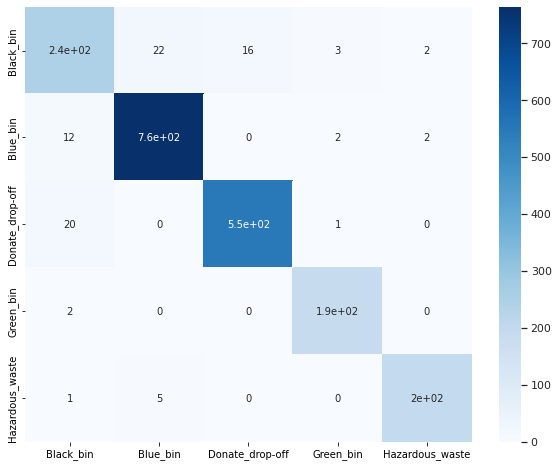

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y_test_class,Y_pred_class)
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = total_ds.class_names
df_cm.index = total_ds.class_names

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_class,Y_pred_class))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       288
           1       0.97      0.98      0.97       780
           2       0.97      0.96      0.97       572
           3       0.97      0.99      0.98       191
           4       0.98      0.97      0.97       201

    accuracy                           0.96      2032
   macro avg       0.95      0.95      0.95      2032
weighted avg       0.96      0.96      0.96      2032



In [ ]:
#narrow down to only recyclable and non-recyclable bins
#0 = non-recyclable
#1 = recycleable
def recycle_classify(labels):
  y = np.copy(labels)
  waste_index = [0,1,0,0,0]
  for i in range(5):
    y = np.where(y == i, waste_index[i], y)
  return y

In [ ]:
Y_recycle_class_pred = recycle_classify(Y_pred_class)
Y_recycle_class_test = recycle_classify(Y_test_class)

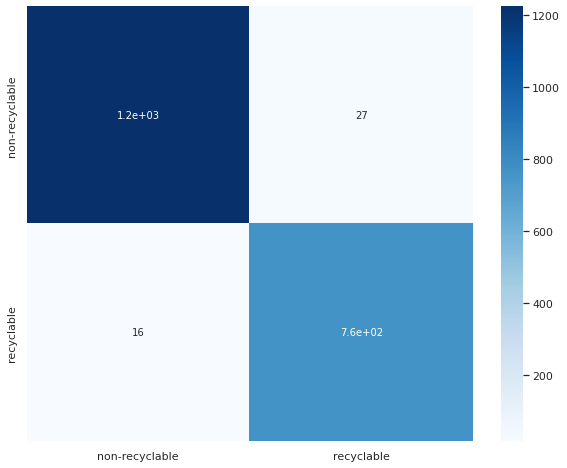

In [ ]:
cm=confusion_matrix(Y_recycle_class_test,Y_recycle_class_pred)
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['non-recyclable','recyclable']
df_cm.index = ['non-recyclable','recyclable']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size
plt.show()

In [ ]:
print(classification_report(Y_recycle_class_test,Y_recycle_class_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1252
           1       0.97      0.98      0.97       780

    accuracy                           0.98      2032
   macro avg       0.98      0.98      0.98      2032
weighted avg       0.98      0.98      0.98      2032

